In [205]:
import re
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize, differential_evolution

mu_sol = 1.32712440018e11  # km^3/s^2

In [206]:
def read_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê o arquivo de dados e retorna todos os parâmetros para uma data específica

    Args:
        date (str): Data no formato 'ano-Mes-dia'
        filename (str): Nome do arquivo de dados

    Returns:
        dict: Dicionário com todos os parâmetros orbitais
    """

    with open(filename, 'r') as file:
        content = file.read()

    pattern = rf'(\d+\.\d+) = A\.D\. {date}.*?(?=\n\d+\.\d+ = A\.D\.|\Z)'
    match = re.search(pattern, content, re.DOTALL)

    if not match:
        raise ValueError(f"Data {date} não encontrada no arquivo")

    block = match.group(0)

    params = {}

    jd_match = re.search(r'(\d+\.\d+) = A\.D\.', block)
    if jd_match:
        params['JDTDB'] = float(jd_match.group(1))

    param_pattern = r'([A-Za-z]+)\s*=\s*([-+]?\s*\d*\.?\d+(?:[Ee][-+]?\d+)?)'
    matches = re.findall(param_pattern, block)

    for key, value in matches:
        value_clean = re.sub(r'\s+', '', value)
        params[key] = float(value_clean)

    return params


In [207]:
def print_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê e imprime todos os parâmetros para uma data específica
    """
    parametros = read_parameters(date, filename)

    print(f"Parâmetros orbitais para {date}:")
    print("=" * 50)

    # Lista de todos os parâmetros na ordem desejada
    parametros_info = [
        ('JDTDB', 'Julian Day Number, Barycentric Dynamical Time'),
        ('EC', 'Eccentricity, e'),
        ('QR', 'Periapsis distance, q (km)'),
        ('IN', 'Inclination w.r.t X-Y plane, i (degrees)'),
        ('OM', 'Longitude of Ascending Node, OMEGA, (degrees)'),
        ('W', 'Argument of Perifocus, w (degrees)'),
        ('Tp', 'Time of periapsis (Julian Day Number)'),
        ('N', 'Mean motion, n (degrees/sec)'),
        ('MA', 'Mean anomaly, M (degrees)'),
        ('TA', 'True anomaly, nu (degrees)'),
        ('A', 'Semi-major axis, a (km)'),
        ('AD', 'Apoapsis distance (km)'),
        ('PR', 'Sidereal orbit period (sec)')
    ]

    for key, description in parametros_info:
        if key in parametros:
            if key == 'JDTDB':
                print(f"{key:4} = {parametros[key]:.6f} # {description}")
            else:
                print(f"{key:4} = {parametros[key]:.15e} # {description}")
        else:
            print(f"{key:4} = NÃO ENCONTRADO # {description}")

In [208]:
orbita1 = print_parameters('1997-Oct-16')
orbita2 = print_parameters('1998-Apr-26')
orbita3 = print_parameters('1998-Dec-03')
orbita4 = print_parameters('1999-Jun-24')
orbita5 = print_parameters('1999-Aug-18')
orbita6 = print_parameters('2000-Dec-30')

Parâmetros orbitais para 1997-Oct-16:
JDTDB = 2450737.500000 # Julian Day Number, Barycentric Dynamical Time
EC   = 2.184496764898922e-01 # Eccentricity, e
QR   = 9.716931021862583e+07 # Periapsis distance, q (km)
IN   = 1.350933724972981e+00 # Inclination w.r.t X-Y plane, i (degrees)
OM   = 2.204067684864096e+01 # Longitude of Ascending Node, OMEGA, (degrees)
W    = 1.992746364113183e+02 # Argument of Perifocus, w (degrees)
Tp   = 2.450620781913819e+06 # Time of periapsis (Julian Day Number)
N    = 1.505636694513279e-05 # Mean motion, n (degrees/sec)
MA   = 1.518350689155998e+02 # Mean anomaly, M (degrees)
TA   = 1.613050063121325e+02 # True anomaly, nu (degrees)
A    = 1.243289232895688e+08 # Semi-major axis, a (km)
AD   = 1.514885363605117e+08 # Apoapsis distance (km)
PR   = 2.391015052382047e+07 # Sidereal orbit period (sec)
Parâmetros orbitais para 1998-Apr-26:
JDTDB = 2450929.500000 # Julian Day Number, Barycentric Dynamical Time
EC   = 2.067972763583760e-01 # Eccentricity, e
QR 

In [209]:
def excentricity(r1, theta1, r2, theta2):
    return abs((r2 - r1) / (r1*np.cos(theta1) - r2*np.cos(theta2)))

def semiaxis(r, e, theta):
    return r * (1 + e * np.cos(theta)) / (1 - e**2)

def angular_momentum(r, theta, e, mu):
    p = r * (1 + e * np.cos(theta))
    if p<0:
        p = -p
    h = np.sqrt(mu * p)
    return h
    # return np.sqrt(mu * r * (1 + e * np.cos(theta)))

def tangencial_velocity(mu, h, e, theta):
    return mu / h * (1 + e * np.cos(theta))

def radial_velocity(mu, h, e, theta):
    return mu / h * e * np.sin(theta)

def velocity_magnitude(mu, h, e, theta):
    return mu / h * np.sqrt(e**2 + 2*e*np.cos(theta) + 1)

In [210]:
def eccentric_anomaly_from_true_anomaly(theta, e):
    if 0 <= e < 1:

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        denominator = 1 + e * cos_theta
        sqrt_value = 1 - e**2
        sin_E = np.sqrt(sqrt_value) * sin_theta / denominator
        cos_E = (e + cos_theta) / denominator

        E = np.arctan2(sin_E, cos_E)
        if E < 0:
            E += 2 * np.pi
        return E


    elif e > 1:

        critical_angle = np.arccos(-1/e)
        if abs(theta - critical_angle) < 1e-10 or abs(theta - (2*np.pi - critical_angle)) < 1e-10:
            # Retornar um valor grande mas finito
            return 10.0 if theta > np.pi else -10.0

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        denominator = 1 + e * cos_theta
        if abs(denominator) < 1e-12:
            return 10.0 if theta > np.pi else -10.0

        # Usar a definição de anomalia excêntrica hiperbólica
        H = 2 * np.arctanh(np.sqrt((e - 1) / (e + 1)) * np.tan(theta / 2))
        return H

def mean_anomaly_from_eccentric_anomaly(E, e):
    """Calcula a anomalia média M a partir da anomalia excêntrica E"""
    if e < 1:
        return E - e * np.sin(E)
    else:
        # Para órbitas hiperbólicas
        return e * np.sinh(E) - E

def orbital_period(a, mu):
    return 2 * np.pi * np.sqrt(a**3 / mu)

def time_from_periapsis(theta, e, a, mu):
    """
    Calcula o tempo desde a passagem pelo periastro para uma dada anomalia verdadeira
    Retorna tempo em segundos
    """
    try:
        E = eccentric_anomaly_from_true_anomaly(theta, e)
        M = mean_anomaly_from_eccentric_anomaly(E, e)

        if e < 1:
            n = np.sqrt(mu / abs(a)**3)  # Movimento médio para elípticas
        else:
            # Para órbitas hiperbólicas, usar a definição apropriada
            n = np.sqrt(mu / abs(a)**3)

        return M / n if theta >= 0 else -M / n
    except Exception as ex:
        print(f"Erro em time_from_periapsis: {ex}")
        return 0

def calculate_travel_time(theta1, theta2, e, a, mu):
    """
    Calcula o tempo para viajar de theta1 a theta2
    Retorna tempo em dias
    """
    try:
        t1 = time_from_periapsis(theta1, e, a, mu)
        t2 = time_from_periapsis(theta2, e, a, mu)

        # Determinar a direção do movimento
        delta_t = t2 - t1

        # Se delta_t é negativo e é órbita elíptica, a nave passou pelo periastro
        if delta_t < 0 and e < 1:
            T = orbital_period(a, mu)
            delta_t += T

        return delta_t / 86400  # Converter para dias
    except Exception as e:
        print(f"Erro no cálculo do tempo: {e}")
        return 0

In [211]:
def plot_orbit(e, a, theta1, theta2, r1, r2):


    """
    Ta bem ruim o plot

    Plota a órbita elíptica com a parte percorrida em linha contínua

    Args:
        e: excentricidade
        a: semi-eixo maior (km)
        theta1, theta2: anomalias verdadeiras inicial e final (graus)
        r1, r2: raios orbital inicial e final (km)
    """
    # Parâmetros da elipse
    if e < 1:
        b = a * np.sqrt(1 - e**2)  # semi-eixo menor
    elif e > 1:
        b = a * np.sqrt(e**2 - 1)  # semi-eixo menor para hipérbole


    c = e * a  # distância do centro ao foco

    # Gera pontos para a órbita completa
    theta_full = np.linspace(0, 2*np.pi, 1000)
    r_full = a * (1 - e**2) / (1 + e * np.cos(theta_full))

    # Converte para coordenadas cartesianas
    x_full = r_full * np.cos(theta_full)
    y_full = r_full * np.sin(theta_full)

    # Gera pontos para a parte percorrida
    if theta2 > theta1:
        theta_traveled = np.linspace(theta1, theta2, 200)
    else:
        # Se theta2 < theta1, assumimos que passa pelo periastro
        theta_traveled = np.concatenate([
            np.linspace(theta1, 2*np.pi, 100),
            np.linspace(0, theta2, 100)
        ])

    r_traveled = a * (1 - e**2) / (1 + e * np.cos(theta_traveled))
    x_traveled = r_traveled * np.cos(theta_traveled)
    y_traveled = r_traveled * np.sin(theta_traveled)

    # Cria a figura
    plt.figure(figsize=(10, 8))

    # Plot da órbita completa (tracejada)
    plt.plot(x_full, y_full, '--', color='gray', alpha=0.7, label='Órbita completa')

    # Plot da parte percorrida (contínua)
    plt.plot(x_traveled, y_traveled, '-', color='blue', linewidth=2, label='Trajetória percorrida')

    # Marca as posições inicial e final
    plt.plot(r1 * np.cos(theta1), r1 * np.sin(theta1), 'go',
             markersize=8, label=f'Início (θ={theta1:.3f}°)')
    plt.plot(r2 * np.cos(theta2), r2 * np.sin(theta2), 'ro',
             markersize=8, label=f'Fim (θ={theta2:.3f}°)')

    # Marca o Sol no foco
    plt.plot(0, 0, 'yo', markersize=15, label='Sol')
    plt.plot(0, 0, 'y*', markersize=20)

    # Marca o periastro e apoastro
    periastro = a * (1 - e)
    apoastro = a * (1 + e)

    plt.plot([-c, -c], [0, 0], 'kx', markersize=8, label='Centro')
    plt.plot([-c + a, -c - a], [0, 0], 'k--', alpha=0.3)  # Linha do semi-eixo maior

    # Configurações do gráfico
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title(f'Órbita Cassini - {data1} a {data2}\n'
              f'e = {e:.4f}, a = {a/1e6:.1f}×10⁶ km')
    plt.legend()

    # Adiciona informações textuais

    textstr = f'Δθ = {theta2 - theta1:.1f}°\n' \
              f'r₁ = {r1/1e6:.1f}×10⁶ km\n' \
              f'r₂ = {r2/1e6:.1f}×10⁶ km\n' \
              f'Periastro = {periastro/1e6:.1f}×10⁶ km\n' \
              f'Apoastro = {apoastro/1e6:.1f}×10⁶ km'

    plt.annotate(textstr, xy=(0.02, 0.98), xycoords='axes fraction',
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Ajusta os limites para melhor visualização
    max_range = max(apoastro, np.max(np.abs(x_full)), np.max(np.abs(y_full)))
    # plt.xlim(-max_range*1.1, max_range*1.1)
    # plt.ylim(-max_range*1.1, max_range*1.1)

    plt.tight_layout()
    plt.savefig('./Plot_Orbitas/orbita_cassini_' + data1 + '_' + data2 + '.png')
    plt.show()

In [212]:
from scipy.optimize import minimize, differential_evolution
import numpy as np

def dados_da_orbita(start, finish, printa_dados=False, plota_orbita=False):
    data1 = read_parameters(start)
    data2 = read_parameters(finish)

    theta1 = np.radians(data1['TA'])
    theta2 = np.radians(data2['TA'])
    r1 = data1['A'] * (1 - data1['EC']**2) / (1 + data1['EC'] * np.cos(theta1))
    r2 = data2['A'] * (1 - data2['EC']**2) / (1 + data2['EC'] * np.cos(theta2))
    w1 = np.radians(data1['W'])
    w2 = np.radians(data2['W'])
    real_time = (data2['JDTDB'] - data1['JDTDB']) # em dias

    def objetivo(w_orbit):
        try:
            # Garante que w_orbit é um escalar
            if hasattr(w_orbit, '__len__'):
                w_orbit = w_orbit[0]
                
            # Calcula theta_linha
            theta_linha_1 = np.mod(theta1 + w1 - w_orbit, 2 * np.pi)
            theta_linha_2 = np.mod(theta2 + w2 - w_orbit, 2 * np.pi)
            
            # Calcula parâmetros orbitais
            e = excentricity(r1, theta_linha_1, r2, theta_linha_2)
            
            # Restringe e para órbitas elípticas (0 < e < 1)
            if not (0 < e < 1):
                return 1e6  # penalização alta

            a = semiaxis(r1, e, theta_linha_1)

            # Verifica se a é positivo
            if a <= 0:
                return 1e6

            # Cálculo do tempo teórico
            theoretical_time = calculate_travel_time(theta_linha_1, theta_linha_2, e, a, mu_sol)

            # Penaliza valores não físicos
            if np.isnan(theoretical_time) or theoretical_time <= 0:
                return 1e6

            # Função objetivo: erro absoluto normalizado
            error = abs(theoretical_time - real_time)
            return error / real_time  # erro relativo

        except Exception as e:
            # Captura qualquer exceção e retorna penalização alta
            return 1e6

    # --- Otimização ---
    w0 = (w1 + w2) / 2.0
    bounds = [(0, 2 * np.pi)]

    # Primeiro tenta com L-BFGS-B (mais rápido)
    resultado = minimize(
        objetivo,
        w0,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 100000, 'ftol': 1e-8}
    )

    # Se falhar ou resultado for ruim, tenta Differential Evolution
    if not resultado.success or resultado.fun > 0.1:  # erro > 10%
        if printa_dados:
            print(f"Otimização local falhou (erro: {resultado.fun:.2%}). Tentando método global...")
        
        try:
            resultado_de = differential_evolution(
                objetivo,
                bounds,
                strategy='best1bin',
                maxiter=100000,
                popsize=10,
                tol=1e-4,
                polish=True,
                seed=42  # para reproducibilidade
            )
            
            if resultado_de.success and resultado_de.fun < resultado.fun:
                resultado = resultado_de
                if printa_dados:
                    print(f"Otimização global melhorou o erro para: {resultado.fun:.2%}")
        except Exception as e:
            if printa_dados:
                print(f"Otimização global falhou: {e}. Usando resultado local.")

    # Se ainda falhar, usa fallback
    if resultado.success:
        w_orbit = float(resultado.x)  # Garante que é escalar
        final_error = resultado.fun
    else:
        if printa_dados:
            print(f"Ambas otimizações falharam para {start}-{finish}. Usando w médio.")
        w_orbit = w0
        final_error = objetivo(w0)

    # Aplica o w_orbit encontrado
    theta1_opt = np.mod(theta1 + w1 - w_orbit, 2 * np.pi)
    theta2_opt = np.mod(theta2 + w2 - w_orbit, 2 * np.pi)

    # Recalcula todos os parâmetros com os ângulos otimizados
    e = excentricity(r1, theta1_opt, r2, theta2_opt)
    a = semiaxis(r1, e, theta1_opt)
    
    # Verificação final de sanidade dos parâmetros
    if not (0 < e < 1) or a <= 0:
        if printa_dados:
            print(f"Parâmetros não físicos após otimização. Usando método direto.")
        # Fallback: usa método direto sem otimização
        e = excentricity(r1, theta1, r2, theta2)
        a = semiaxis(r1, e, theta1)
        theta1_opt, theta2_opt = theta1, theta2
        w_orbit = w0

    h = angular_momentum(r1, theta1_opt, e, mu_sol)
    vr1 = radial_velocity(mu_sol, h, e, theta1_opt)
    vt1 = tangencial_velocity(mu_sol, h, e, theta1_opt)
    v1 = velocity_magnitude(mu_sol, h, e, theta1_opt)
    vr2 = radial_velocity(mu_sol, h, e, theta2_opt)
    vt2 = tangencial_velocity(mu_sol, h, e, theta2_opt)
    v2 = velocity_magnitude(mu_sol, h, e, theta2_opt)
    
    theoretical_time = calculate_travel_time(theta1_opt, theta2_opt, e, a, mu_sol)
    erro_percentual = abs((theoretical_time - real_time) / real_time) * 100

    if printa_dados:
        print(f"\nParâmetros calculados entre {start} e {finish}:")
        print("=" * 60)
        print(f"w_orbit otimizado: {np.degrees(w_orbit):.3f}°")
        print(f"Erro da otimização: {final_error:.2%}")
        print(f"Excentricidade: {e:.6f}")
        print(f"Semi-eixo maior: {a:.2e} km")
        print(f"Momento angular: {h:.2e} km²/s")
        print(f"Velocidade inicial {start}:")
        print(f"  vr = {vr1:.3f} km/s, vt = {vt1:.3f} km/s, v_total = {v1:.3f} km/s")
        print(f"Velocidade final {finish}:")
        print(f"  vr = {vr2:.3f} km/s, vt = {vt2:.3f} km/s, v_total = {v2:.3f} km/s")
        print(f"Tempo real: {real_time:.2f} dias")
        print(f"Tempo teórico: {theoretical_time:.2f} dias")
        print(f"Erro final: {erro_percentual:.2f}%")
        print("=" * 60)

    if plota_orbita:
        plot_orbit(e, a, theta1_opt, theta2_opt, r1, r2)

    return {
        'e': e,
        'a': a,
        'h': h,
        'theta_1': theta1_opt,
        'theta_2': theta2_opt,
        'vr_start': vr1,
        'vt_start': vt1,
        'v_start': v1,
        'vr_end': vr2,
        'vt_end': vt2,
        'v_end': v2,
        'real_time_days': real_time,
        'theoretical_time_days': theoretical_time,
        'w_orbit': w_orbit,
        'error_percent': erro_percentual,
        'optimization_error': final_error
    }

In [213]:
def trajetoria_completa(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6):
    """
    Plota a trajetória completa usando as órbitas otimizadas
    """
    orbitas = [orbita1, orbita2, orbita3, orbita4, orbita5, orbita6]
    nomes_orbitas = ['Órbita 1', 'Órbita 2', 'Órbita 3', 'Órbita 4', 'Órbita 5', 'Órbita 6']
    cores = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
    
    plt.figure(figsize=(12, 10))
    
    # Para manter a continuidade angular entre órbitas
    longitude_acumulada = 0
    
    for i, orbita in enumerate(orbitas):
        if orbita is None or np.isnan(orbita['e']):
            print(f"Órbita {i+1} não disponível para plotagem")
            continue
            
        e = orbita['e']
        a = orbita['a']
        theta1 = orbita['theta_1']
        theta2 = orbita['theta_2']
        w_orbit = orbita['w_orbit']
        
        # Longitude para plotagem = theta_linha + w_orbit + longitude_acumulada
        lon1 = theta1 + w_orbit + longitude_acumulada
        lon2 = theta2 + w_orbit + longitude_acumulada
        
        # Garante continuidade angular
        if i > 0 and abs(lon1 - lon_anterior) > np.pi:
            if lon1 < lon_anterior:
                lon1 += 2 * np.pi
                lon2 += 2 * np.pi
        
        # Gera pontos para plotagem
        theta_plot = np.linspace(theta1, theta2, 300)
        r_plot = a * (1 - e**2) / (1 + e * np.cos(theta_plot))
        lon_plot = theta_plot + w_orbit + longitude_acumulada
        
        x_plot = r_plot * np.cos(lon_plot)
        y_plot = r_plot * np.sin(lon_plot)
        
        # Plota a trajetória
        plt.plot(x_plot, y_plot, color=cores[i], linewidth=2, label=nomes_orbitas[i], alpha=0.8)
        
        # Marca início e fim
        r1 = a * (1 - e**2) / (1 + e * np.cos(theta1))
        r2 = a * (1 - e**2) / (1 + e * np.cos(theta2))
        
        plt.plot(r1 * np.cos(lon1), r1 * np.sin(lon1), 'o', 
                color=cores[i], markersize=6, markeredgecolor='black')
        plt.plot(r2 * np.cos(lon2), r2 * np.sin(lon2), 's', 
                color=cores[i], markersize=6, markeredgecolor='black')
        
        # Atualiza para próxima órbita
        longitude_acumulada = lon2 - orbita['theta_2'] - orbita['w_orbit']
        lon_anterior = lon2
    
    # Sol no centro
    plt.plot(0, 0, 'yo', markersize=20, label='Sol')
    plt.plot(0, 0, 'y*', markersize=25)
    
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Trajetória Completa da Cassini (Com Otimização de w_orbit)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Informações resumidas
    info_texto = "Resumo das Órbitas Otimizadas:\n\n"
    for i, orbita in enumerate(orbitas):
        if orbita is not None and not np.isnan(orbita['e']):
            info_texto += f"{nomes_orbitas[i]}:\n"
            info_texto += f"  w_orbit = {np.degrees(orbita['w_orbit']):.2f}°\n"
            info_texto += f"  e = {orbita['e']:.3f}, a = {orbita['a']/1e6:.1f}×10⁶ km\n"
            info_texto += f"  Erro tempo: {orbita['error_percent']:.1f}%\n\n"
    
    plt.annotate(info_texto, xy=(0.02, 0.02), xycoords='axes fraction',
                verticalalignment='bottom', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [214]:
def velocity_variation(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6):
    """
    Calcula as variações nas velocidades para cada mudança de orbita
    """
    # Lista de todas as órbitas
    orbitas = [orbita1, orbita2, orbita3, orbita4, orbita5]#, orbita6]
    deltav_r = []
    delatv_t = []
    deltav_total = []

    # pares
    for i in range(len(orbitas)-1):

        vr_final_1 = orbitas[i]['vr_end']
        vt_final_1 = orbitas[i]['vt_end']

        vr_inicial_2 = orbitas[i+1]['vr_start']
        vt_inicial_2 = orbitas[i+1]['vt_start']

        deltav_r.append(vr_inicial_2 - vr_final_1)
        delatv_t.append(vt_inicial_2 - vt_final_1)
        deltav_total.append(math.sqrt((vr_inicial_2 - vr_final_1)**2 + (vt_inicial_2 - vt_final_1)**2))


    return {
        'delta_v_r': np.array(deltav_r),
        'delta_v_t': np.array(delatv_t),
        'delta_v_total': np.array(deltav_total)
        }


In [215]:
orbita1 = dados_da_orbita('1997-Oct-16', '1998-Apr-26', printa_dados=True, plota_orbita=False)
orbita2 = dados_da_orbita('1998-Apr-26', '1998-Dec-03', printa_dados=True, plota_orbita=False)
orbita3 = dados_da_orbita('1998-Dec-03', '1999-Jun-24', printa_dados=True, plota_orbita=False)
orbita4 = dados_da_orbita('1999-Jun-24', '1999-Aug-18', printa_dados=True, plota_orbita=False)
orbita5 = dados_da_orbita('1999-Aug-18', '2000-Dec-30', printa_dados=True, plota_orbita=False)
orbita6 = dados_da_orbita('2000-Dec-30', '2004-Jul-01', printa_dados=True, plota_orbita=False)

C:\Users\JoaoBento\AppData\Local\Temp\ipykernel_15756\2556748962.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_orbit = float(resultado.x)  # Garante que é escalar



Parâmetros calculados entre 1997-Oct-16 e 1998-Apr-26:
w_orbit otimizado: 198.456°
Erro da otimização: 0.00%
Excentricidade: 0.206002
Semi-eixo maior: 1.25e+08 km
Momento angular: 3.99e+09 km²/s
Velocidade inicial 1997-Oct-16:
  vr = 2.103 km/s, vt = 26.734 km/s, v_total = 26.816 km/s
Velocidade final 1998-Apr-26:
  vr = 5.875 km/s, vt = 36.775 km/s, v_total = 37.242 km/s
Tempo real: 192.00 dias
Tempo teórico: 192.00 dias
Erro final: 0.00%
Otimização local falhou (erro: 0.00%). Tentando método global...
Ambas otimizações falharam para 1998-Apr-26-1998-Dec-03. Usando w médio.

Parâmetros calculados entre 1998-Apr-26 e 1998-Dec-03:
w_orbit otimizado: 201.200°
Erro da otimização: 20.10%
Excentricidade: 0.430870
Semi-eixo maior: 1.65e+08 km
Momento angular: 4.22e+09 km²/s
Velocidade inicial 1998-Apr-26:
  vr = 11.263 km/s, vt = 38.925 km/s, v_total = 40.522 km/s
Velocidade final 1998-Dec-03:
  vr = 0.787 km/s, vt = 17.903 km/s, v_total = 17.920 km/s
Tempo real: 221.00 dias
Tempo teórico: 

In [216]:
velocity_variation(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6)

{'delta_v_r': array([ 5.38810319, -0.40675653, 32.59050484, 18.4811975 ]),
 'delta_v_t': array([  2.14959973,   0.49205747, -26.23106896,  26.6188738 ]),
 'delta_v_total': array([ 5.80107189,  0.63841321, 41.83551105, 32.40554125])}

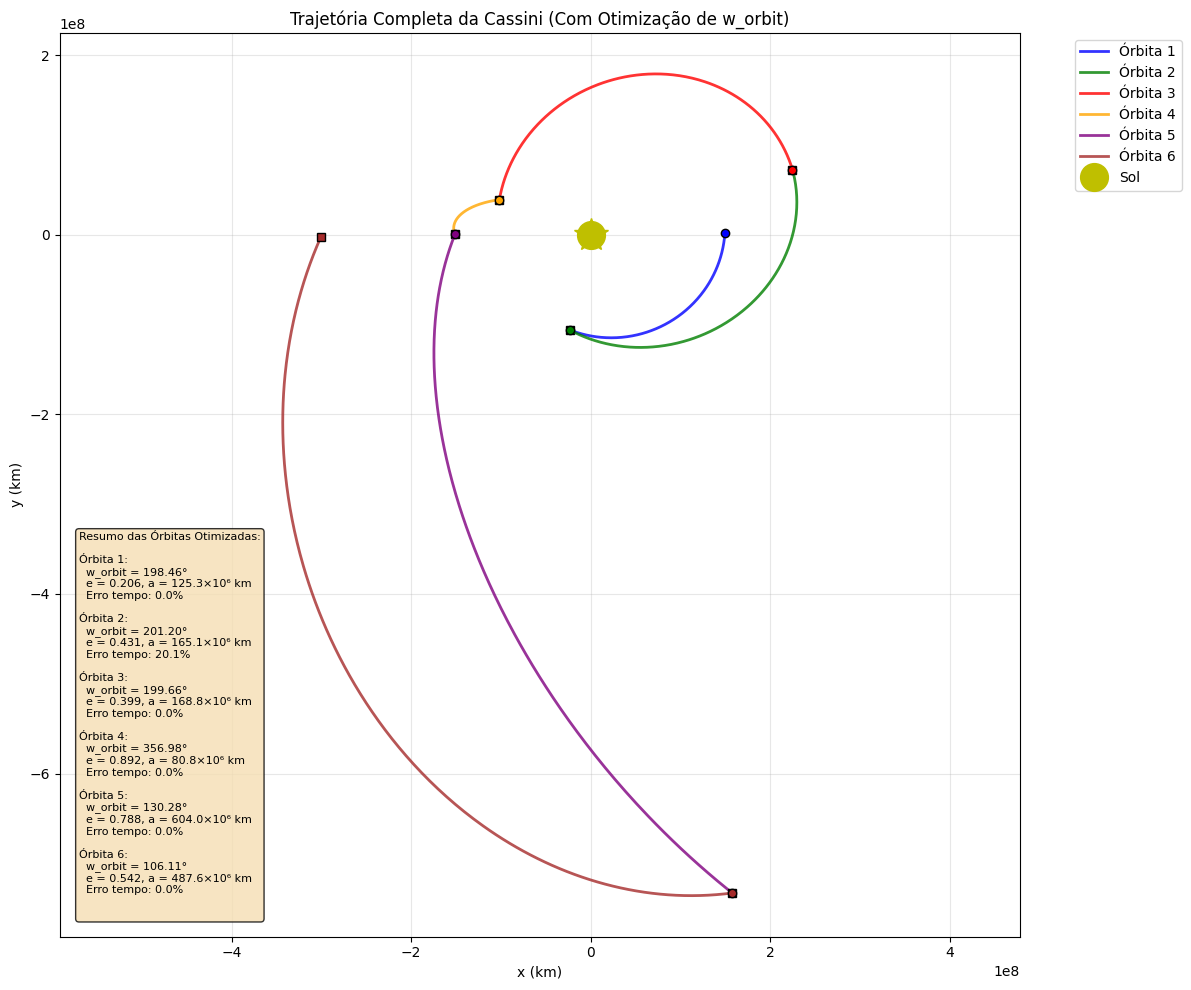

In [217]:
trajetoria_completa(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6)